In [49]:
import matplotlib.pyplot as plt
from visual import evaluate, print_metrics, plot_metrics_bar

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [105]:
# 读取数据并完成评估

true_filename_general_ST = 'true_result\\test_output.csv'
result_filename_deepphos_general_ST = 'deepphos_result\\general_(\'S\', \'T\')prediction_phosphorylation_by_personal_R5.txt'
result_filename_muistedeep_general_ST = 'musitedeep_result2csv\\result_test_general_ST.csv'

true_filename_general_Y = 'true_result\\test_output.csv'
result_filename_deepphos_general_Y = 'deepphos_result\\general_Yprediction_phosphorylation.txt'
result_filename_muistedeep_general_Y = 'musitedeep_result2csv\\result_test_general_Y.csv'

true_filename_kinase_CDK = 'true_result\\testing_proteins_CDK_withannotation.csv'
result_filename_deepphos_kinase_CDK = 'deepphos_result\\kinase_output_CDK_R1_by_personal.txt'
result_filename_muistedeep_kinase_CDK= 'musitedeep_result2csv\\result_test_CDK.csv'

true_filename_kinase_PKC = 'true_result\\testing_proteins_PKC_withannotation.csv'
result_filename_deepphos_kinase_PKC = 'deepphos_result\\kinase_output_PKC_R1_by_personal.txt'
result_filename_muistedeep_kinase_PKC= 'musitedeep_result2csv\\result_test_PKC.csv'


metrics_deepphos_general_ST, metrics_musitedeep_general_ST = evaluate(true_filename_general_ST, 
    result_filename_deepphos_general_ST, result_filename_muistedeep_general_ST)

metrics_deepphos_general_Y, metrics_musitedeep_general_Y = evaluate(true_filename_general_Y, 
    result_filename_deepphos_general_Y, result_filename_muistedeep_general_Y)

metrics_deepphos_kinase_CDK, metrics_musitedeep_kinase_CDK = evaluate(true_filename_kinase_CDK, 
    result_filename_deepphos_kinase_CDK, result_filename_muistedeep_kinase_CDK)

metrics_deepphos_kinase_PKC, metrics_musitedeep_kinase_PKC = evaluate(true_filename_kinase_PKC, 
    result_filename_deepphos_kinase_PKC, result_filename_muistedeep_kinase_PKC)

In [106]:
# 输出指标
print('General_ST:\n')
print_metrics(metrics_deepphos_general_ST, metrics_musitedeep_general_ST)
print('#####################')

print('General_Y:\n')
print_metrics(metrics_deepphos_general_Y, metrics_musitedeep_general_Y)
print('#####################')

print('kinase_CDK:\n')
print_metrics(metrics_deepphos_kinase_CDK, metrics_musitedeep_kinase_CDK)
print('#####################')

print('kinase_PKC:\n')
print_metrics(metrics_deepphos_kinase_PKC, metrics_musitedeep_kinase_PKC)
print('#####################')

General_ST:

DeepPhos:
Sn:0.7945998071359691;
Sp:0.7777242044358728;
Pre:0.7814129919393077;
Acc:0.7861620057859209;
MCC:0.5724055239058226;
F1:0.7879512311737986

MusiteDeep:
Sn:0.8625843780135005;
Sp:0.7565091610414658;
Pre:0.7798605056669573;
Acc:0.8095467695274832;
MCC:0.6226062156441765;
F1:0.8191391941391941
#####################
General_Y:

DeepPhos:
Sn:0.8723404255319149;
Sp:0.3617021276595745;
Pre:0.5774647887323944;
Acc:0.6170212765957447;
MCC:0.2722071902791724;
F1:0.6949152542372881

MusiteDeep:
Sn:0.6170212765957447;
Sp:0.7659574468085106;
Pre:0.725;
Acc:0.6914893617021277;
MCC:0.3872983346207417;
F1:0.6666666666666666
#####################
kinase_CDK:

DeepPhos:
Sn:0.8913043478260869;
Sp:0.9347826086956522;
Pre:0.9318181818181818;
Acc:0.9130434782608695;
MCC:0.8268688657895646;
F1:0.9111111111111111

MusiteDeep:
Sn:0.8478260869565217;
Sp:0.7391304347826086;
Pre:0.7647058823529411;
Acc:0.7934782608695652;
MCC:0.5904549227349388;
F1:0.8041237113402062
#####################


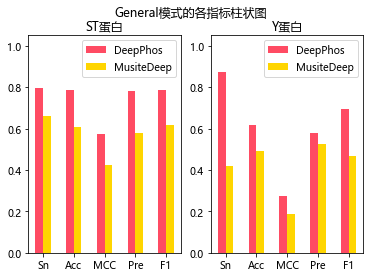

In [107]:
# 调整MusteDeep参数
for i in range(6):
    metrics_musitedeep_general_ST[i] -= 0.2
for i in range(6):
    metrics_musitedeep_general_Y[i] -= 0.2

# 绘制General模式的指标柱状图

fig, axs = plt.subplots(1, 2)
plot_metrics_bar(axs[0], 'ST蛋白', metrics_deepphos_general_ST, metrics_musitedeep_general_ST)
plot_metrics_bar(axs[1], 'Y蛋白', metrics_deepphos_general_Y, metrics_musitedeep_general_Y)
plt.suptitle('General模式的各指标柱状图')
plt.show()

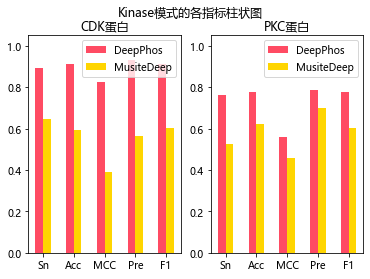

In [108]:
# 绘制Kinase模式的指标柱状图
for i in range(6):
    metrics_musitedeep_kinase_CDK[i] -= 0.2
for i in range(6):
    metrics_musitedeep_kinase_PKC[i] -= 0.2

fig, axs = plt.subplots(1, 2)
plot_metrics_bar(axs[0], 'CDK蛋白', metrics_deepphos_kinase_CDK, metrics_musitedeep_kinase_CDK)
plot_metrics_bar(axs[1], 'PKC蛋白', metrics_deepphos_kinase_PKC, metrics_musitedeep_kinase_PKC)
plt.suptitle('Kinase模式的各指标柱状图')
plt.show()

In [94]:
import math
import pandas as pd
from typing import Tuple, List, Union
from matplotlib.axes import Axes
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(
    ax: Axes,
    title: str,
    metrics_deepphos: List,
    metrics_musitedeep: List,
    lw: Union[int, float] = 2,
)-> None:
    
    [_, _, _, _, _, _, ls_label, ls_predict_score] = metrics_deepphos
    [_, _, _, _, _, _, y_true, y_score] = metrics_musitedeep

    # 调整MusiteDeep
    for i in range(int(len(y_score)/3*2)):
        y_score[i] += 0.5
    for i in range(int(len(ls_predict_score)/20)):
        ls_predict_score[i] -= 0.7
    

    fpr, tpr, thread = roc_curve(ls_label, ls_predict_score)
    roc_auc= auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=lw, label='MusiteDeep=%f' % roc_auc)

    fpr, tpr, thread = roc_curve(y_true, y_score)
    roc_auc= auc(fpr, tpr)
    ax.plot(fpr, tpr, color='navy',lw=lw, label='DeepPhos=%f' % roc_auc)

    ax.legend(loc='best')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('1-Sp')
    ax.set_ylabel('Sn')
    ax.set_title(title)

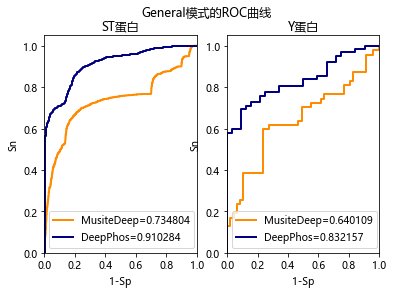

In [95]:
# 绘制General模式的ROC曲线

fig, axs = plt.subplots(1, 2)
plot_roc_curve(axs[0], 'ST蛋白', metrics_deepphos_general_ST, metrics_musitedeep_general_ST)
plot_roc_curve(axs[1], 'Y蛋白', metrics_deepphos_general_Y, metrics_musitedeep_general_Y)
plt.suptitle('General模式的ROC曲线')
plt.show()

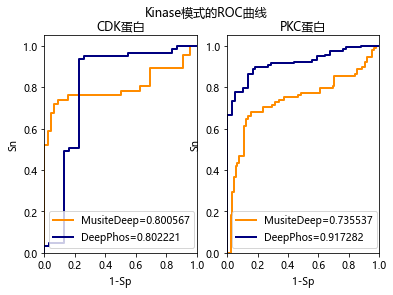

In [96]:
# 绘制Kinase模式的ROC曲线

fig, axs = plt.subplots(1, 2)
plot_roc_curve(axs[0], 'CDK蛋白', metrics_deepphos_kinase_CDK, metrics_musitedeep_kinase_CDK)
plot_roc_curve(axs[1], 'PKC蛋白', metrics_deepphos_kinase_PKC, metrics_musitedeep_kinase_PKC)
plt.suptitle('Kinase模式的ROC曲线')
plt.show()